## Imports, SER load

400
400
400
400
400
400
400
400
400


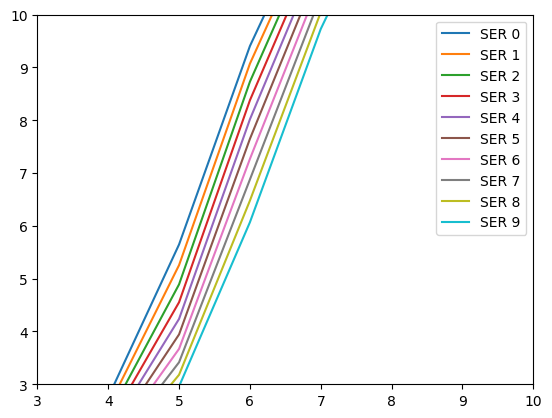

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft

debugging=True
# debugging=False

## Care with root imports/loads, seems to crash the heap/malloc issues, use .npy if poss instead 
# import ROOT
# file = ROOT.TFile.Open('new_digi_arapuca_sbnd.root','READ')
# new_SER =np.array(file.Get("SinglePEVec_40ftCable_Daphne"))
# file.Close()
# np.save("new_SER",new_SER)

new_SER=np.load("new_SER.npy")

SER=[]
SER.append(new_SER[0::10])
if debugging: plt.plot(SER[0])

for i in  range(1,10):
    SER.append(np.insert(new_SER[10-i::10],0,0))
    if debugging: 
        plt.plot(SER[i])
        plt.xlim(3,10)
        plt.ylim(3,10)
if debugging: plt.legend(["SER {}".format(i) for i in range(10)]);

for i in  range(1,10):
    SER[i]=SER[i][:-1]
    if debugging: print(len(SER[i]))

## Singal/Noise functions

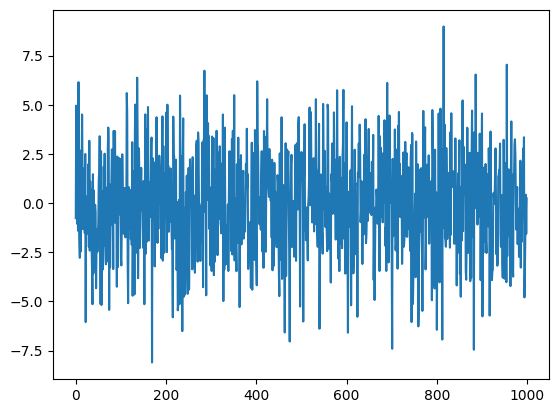

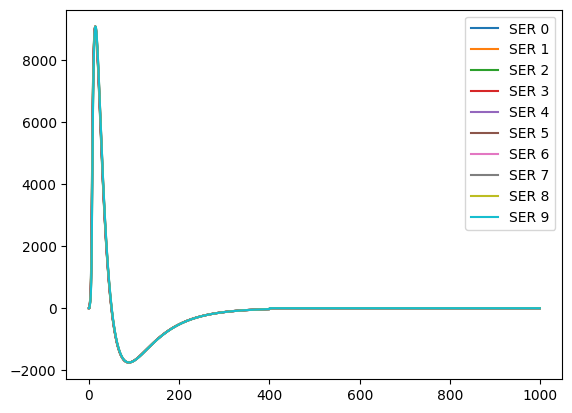

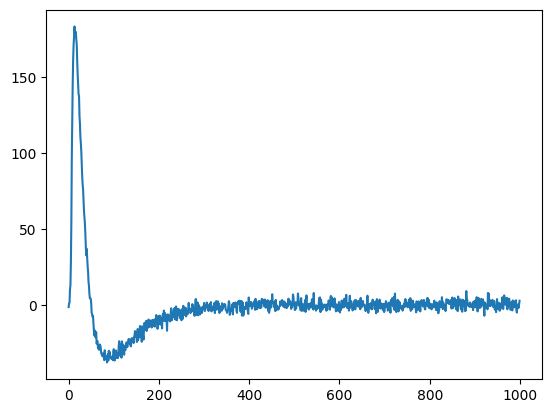

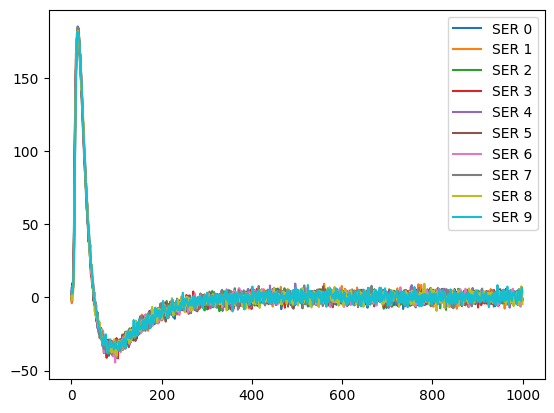

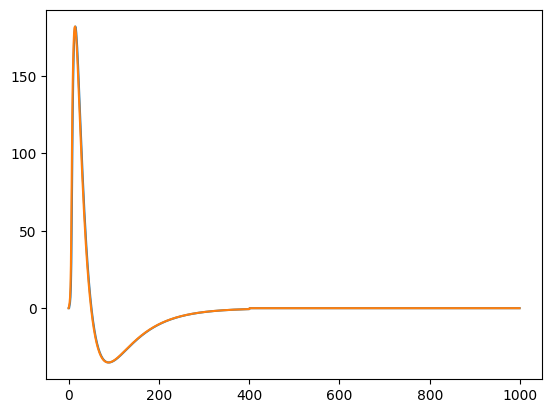

In [2]:
from functions import Add_GaussNoise,Add_signal,Add_signal_OLD,Produce_WVFS

if debugging: plt.plot(Add_GaussNoise(np.zeros(1000)));
if debugging: 
    plt.figure()

    for i in range(10):
        plt.plot(Add_signal(np.zeros(1000),SER,time=float(1+i/10)))
    # plt.xlim(3,10)
    # plt.ylim(3,10)
    plt.legend(["SER {}".format(i) for i in range(10)]);

    plt.figure()
    plt.plot(Add_GaussNoise(  Add_signal(np.zeros(1000),SER,time=1,npe=10)  ))

    plt.figure()

    for i in range(10):
        plt.plot(Add_GaussNoise(  Add_signal(np.zeros(1000),SER,time=float(1+i/10),npe=10)  ))
    # plt.xlim(3,10)
    # plt.ylim(3,100)
    plt.legend(["SER {}".format(i) for i in range(10)]);

if debugging:
    plt.figure()

    # plt.xlim(3,10)
    # plt.ylim(3,100)
    plt.plot((  Add_signal    (np.zeros(1000),SER,time=1.9,npe=10)  ))
    plt.plot((  Add_signal_OLD(np.zeros(1000),SER,time=1.9,npe=10)  ))


## WVF Production

In [3]:
from functions import Produce_WVFS,rand_scint
import awkward as ak
PRE_TIME=80
FREQ    =1/(12.5e-9)
WVF_SIZE=int(12.5e-6*FREQ)
N_WVF   = 1000
N_PHOTO = np.random.randint(low=5 ,high=10,size=N_WVF)
T_TRUTH = ak.Array([rand_scint(photons,fast=6/12.5,slow=1300/12.5)+PRE_TIME for photons in N_PHOTO])
# T_TRUTH = [rand_scint(photons,fast=0.00001,slow=1300/12.5)+PRE_TIME for photons in N_PHOTO]


WVF,WVF_OLD=Produce_WVFS(
WVF_SIZE,
N_WVF,
T_TRUTH,
N_PHOTO,
SER
)

WVF=np.array(WVF)

WVF    =WVF    [np.max(WVF,axis=1)>10]
N_WVF  =len(WVF)
T_TRUTH=T_TRUTH[np.max(WVF,axis=1)>10]
t_truth=np.array([min(T_TRUTH[i]) for i in range(N_WVF)])

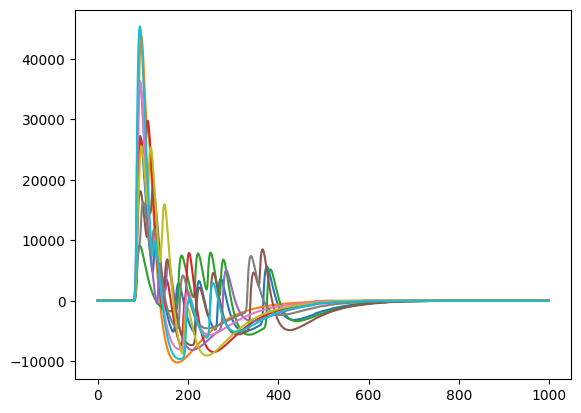

In [4]:
for i in range(10):
    plt.plot(WVF[i])

## WVF analysis

### Gauss filtering

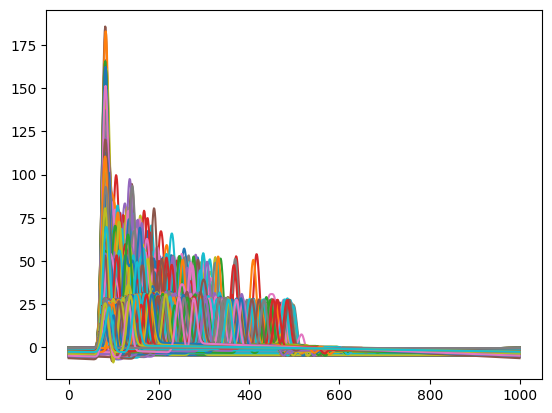

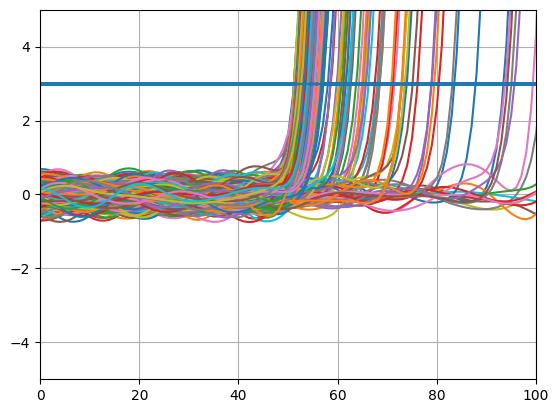

In [5]:
WVF_FILTERED    =[]
WVF_FILTERED_OLD=[]

def make_GaussFilter(wvf,omega_cut=0.002558):
    # Creates a gauss filter with WVF size in the frequency domain with charactheristic frecency OMEGA_CUT in GHz
    gaus_f   =np.exp(- (np.arange(len(wvf))*0.08/WVF_SIZE/ omega_cut )**2)
    gaus_f[0]=0;
    return gaus_f;

def Remove_pedestal(wvf,nbins=50):
    ped=np.mean(wvf[:nbins])
    # if debugging:print(ped)
    
    return wvf-ped;T_RECO,
# T_RECO_FIT_PEAK,
# T_RECO_FIT_RISE_LINEAR,
# T_RECO_FIT_RISE_GAUSS,
# T_RECO_FIT_RAW,


for wvf in WVF:
    wvf_f  =fft.rfft(wvf)
    gauss_f=make_GaussFilter(wvf_f);
    numerator=np.zeros(WVF_SIZE);
    numerator[:len(SER[0])]=SER[0];

    wvf_filtered=fft.irfft(wvf_f/fft.rfft(numerator)*gauss_f)
    WVF_FILTERED.append(wvf_filtered)

    if debugging: plt.plot(wvf_filtered)

for wvf in WVF_OLD:
    wvf_f  =fft.rfft(wvf)
    gauss_f=make_GaussFilter(wvf_f);
    numerator=np.zeros(WVF_SIZE);
    numerator[:len(SER[0])]=SER[0];

    wvf_filtered=fft.irfft(wvf_f/fft.rfft(numerator)*gauss_f)
    WVF_FILTERED_OLD.append(wvf_filtered)

    if debugging: plt.plot(wvf_filtered)

for i in range(N_WVF):
    WVF_FILTERED[i]=Remove_pedestal( WVF_FILTERED[i] )*100

if debugging:
    #baseline never croses 3
    plt.figure()
    for wvf in WVF_FILTERED:
        plt.plot(wvf)
        plt.xlim([0,100])
        plt.ylim([-5,5])
        plt.grid(True)
        plt.hlines(3,0,100)

In [6]:
# %matplotlib qt
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def gaus_deriv(x,a,x0):
    sigma=8 #fixed
    return -a*(x-x0)*np.exp(-(x-x0)**2/(2*sigma**2))


### Filtered


In [7]:
# %matplotlib qt

# i=7

# plt.plot(WVF                            [i])
# plt.plot(WVF_FILTERED                   [i])
# plt.plot(np.gradient(WVF_FILTERED       [i]))
# plt.vlines(T_RECO                       [i],0,5,color="red")
# plt.vlines(T_RECO_DERIVATIVE            [i],0,5,color="black")
# plt.vlines(t_truth                      [i],0,5)
# plt.xlim                        (t_truth[i]-30,t_truth
#                                         [i]+50)
# print(T_TRUTH[i])


In [8]:
import scipy.signal
scipy.signal.find_peaks(WVF_FILTERED[0],height=2)

## Find the peaks

T_RECO                 =np.zeros(N_WVF) -999
T_RECO_FIT_PEAK        =np.zeros(N_WVF) -999
T_RECO_FIT_RISE_LINEAR =np.zeros(N_WVF) -999
T_RECO_FIT_RISE_GAUSS  =np.zeros(N_WVF) -999
T_RECO_DERIVATIVE      =np.zeros(N_WVF) -999
T_RECO_DERIVATIVE_2POINTS=np.zeros(N_WVF) -999
T_RECO_DERIVATIVE_POINT=np.zeros(N_WVF) -999

for i in range(N_WVF):
    
 

    idx_max   = scipy.signal.find_peaks(WVF_FILTERED[i],height=1.5)[0][0];
    idx_third = np.argwhere(WVF_FILTERED[i]>(1/3*scipy.signal.find_peaks(WVF_FILTERED[i],height=1)[1]["peak_heights"][0])) [0][0];
    
    # Old (wvf peak)
    T_RECO    [i]=    idx_max;

    #Gaus peak fit
    try:
        x=np.arange(idx_max-5,idx_max+5)
        y=WVF_FILTERED[i][x]

        popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),x[np.argmax(y)],5])
        T_RECO_FIT_PEAK[i]=popt[1]
    except: #no good fit available, keep the peak instead
        T_RECO_FIT_PEAK[i]=idx_max

    #linear fit to rise

    try:
        x=np.arange(idx_third-2,idx_third+5)
        y=WVF_FILTERED[i][x]
        m, x0 = np.polyfit(x, y, 1)
        T_RECO_FIT_RISE_LINEAR[i]=-x0/m
    except: #no good fit available, keep the peak instead
        T_RECO_FIT_RISE_LINEAR[i]=idx_third
    
    # Gaus fit to rise
    try:
        x=np.arange(idx_third-2,idx_third+7)
        y=WVF_FILTERED[i][x]
        popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),x[np.argmax(y)],5])
        T_RECO_FIT_RISE_GAUSS[i]=popt[1]
    except: #no good fit available, keep the peak instead
        T_RECO_FIT_RISE_GAUSS[i]=idx_max

    #Derivative max point
    # T_RECO_DERIVATIVE[i]=scipy.signal.find_peaks(np.gradient(WVF_FILTERED[i]),height=.5)[0][0]
        #Derivative max point
    idx_max=scipy.signal.find_peaks(np.gradient(WVF_FILTERED[i]),height=.3)[0][0]
    idx_min=scipy.signal.find_peaks(-np.gradient(WVF_FILTERED[i]),height=.3)[0][0]
    A=scipy.signal.find_peaks(np.gradient(WVF_FILTERED[i]),height=.3)[1]["peak_heights"][0]

    x=np.arange(idx_max-3,idx_max+3)
    y=np.gradient(WVF_FILTERED[i])[x]
    popt,pcov=curve_fit(gaus_deriv,x,y,p0=[A,(idx_max+idx_min)/2])
    T_RECO_DERIVATIVE[i]=popt[1]
    T_RECO_DERIVATIVE_2POINTS[i]=(idx_max+idx_min)/2
    T_RECO_DERIVATIVE_POINT[i]=idx_max


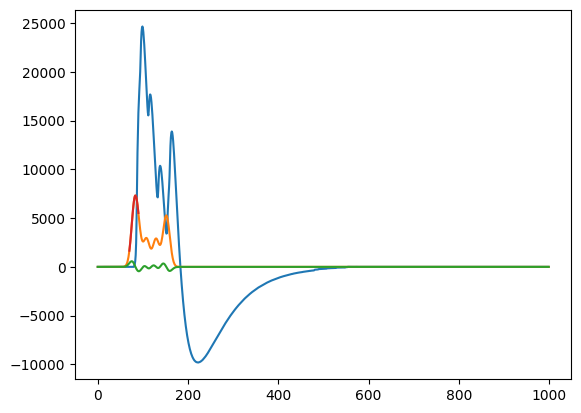

In [9]:
plt.figure()

plt.plot(WVF[i])
plt.plot(WVF_FILTERED[i])
plt.plot(np.gradient(WVF_FILTERED[i]))


x=np.arange(idx_third-2,idx_third+19)
y=WVF_FILTERED[i][x]
plt.plot(x,y)
# popt,pcov = curve_fit(gaus,x,y,p0=[np.max(y),x[np.argmax(y)],5])
# T_RECO_FIT_RISE_GAUSS[i]=popt[1]

# print(t_truth[i],popt[1])

### Results

In [15]:
%matplotlib qt
plt.figure(dpi=100)
for results in [
T_RECO,
T_RECO_FIT_PEAK,
# T_RECO_FIT_RISE_LINEAR,
# T_RECO_FIT_RISE_GAUSS-1,
T_RECO_DERIVATIVE,
# T_RECO_DERIVATIVE_POINT,
# T_RECO_DERIVATIVE_2POINTS,
]:

    # plt.hist(((results-t_truth) - np.mean(results-t_truth))*12.5   ,100,[-20,20],alpha=.5);
    plt.hist(((results-t_truth) )*12.5   ,100,[-100,100],alpha=.5);

plt.legend(["Old                ", 
            "Peak gaussian fit  ",
            # "linear fit (rising)",
            # "Gauss fit (rising) ",
            # "Raw fit exp4 (rising) ",
            "Derivative fit     "], loc='upper left')
plt.xlabel("$\Delta T: T_{Reco}-T_{Truth}$ (ns)");
plt.ylabel("Entries");
plt.semilogy()

print("STD->Old                :","{:.2f}".format(np.std( (T_RECO           -t_truth)*12.5                                           )))
print("STD->Peak gaussian fit  :","{:.2f}".format(np.std( (T_RECO_FIT_PEAK  -t_truth)*12.5                                           )))
print("STD->linear fit (rising):","{:.2f}".format(np.std( (T_RECO_FIT_RISE_LINEAR-t_truth)*12.5                                   )))
print("STD->Gauss fit (rising) :","{:.2f}".format(np.std( (T_RECO_FIT_RISE_GAUSS -t_truth   )*12.5                                   )))
# print("STD->Raw   fit (rising) :","{:.2f}".format(np.std( (T_RECO_FIT_RAW   -t_truth)*12.5-np.mean((T_RECO_FIT_RAW   -t_truth))*12.5 )))
print("STD->Derivative fit     :","{:.2f}".format(np.std( (T_RECO_DERIVATIVE -t_truth   )*12.5                                   )))
print("STD->Derivative point     :","{:.2f}".format(np.std( (T_RECO_DERIVATIVE_POINT -t_truth   )*12.5                                   )))
print("STD->Derivative 2points   :","{:.2f}".format(np.std( (T_RECO_DERIVATIVE_2POINTS -t_truth   )*12.5                                   )))

# plt.semilogy()


STD->Old                : 41.25
STD->Peak gaussian fit  : 40.68
STD->linear fit (rising): 15.55
STD->Gauss fit (rising) : 31.96
STD->Derivative fit     : 15.31
STD->Derivative point     : 13.90
STD->Derivative 2points   : 47.10


In [24]:
# global resolution as a function of the #signals
import random
N_signals=100

#unbias the sample
# plt.hist((T_RECO_FIT_RAW-t_truth-np.mean((T_RECO_FIT_RAW   -t_truth)))*12.5,20,[-10,10] )
ls=[]
ls2=[]
for i in range(array_len):
    sel=random.sample(range(N_WVF),N_signals)

    sel_signals_gaus=(T_RECO_DERIVATIVE[sel]-t_truth[sel])*12.5
    ls2.append(min(sel_signals_gaus))

# plt.hist(ls2,40,[-20,40] )
plt.hist(ls2,20 )

ls2=np.array(ls2)

print(np.std(ls2), len(ls2[(ls2>(np.mean(ls2)-2*np.std(ls2))) & 
                         (ls2<(np.mean(ls2)+2*np.std(ls2))) ])/len(ls2) )


62.42122858607612 0.864


In [28]:
[(T_RECO_DERIVATIVE-t_truth)<-100/12.5]

array([ 84.51541184,  86.64951104,  86.03839549,  85.35399002,
        86.55501486,  98.65573548, 123.40438776,  85.56043956,
        85.71296559,  85.24525064,  86.02561041,  84.5959768 ,
        87.45295822,  84.70708212,  96.46060904])